<a href="https://colab.research.google.com/github/aharrisonau/Task-7.1D/blob/main/Task_7_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SIT796 Reinforcement Learning
##Distinction Task 7.1: Function approximation implementation

This task follows up 1.2C, which was the definition of a truck trailer reversing problem.

In this task, the aim is to set up a policy value mapping for truck reversal.  To achieve this, the state space has been mapped to 4 variables;
- pivot X [0 - 30] metres
- pivot Y [-10 - 30] metres
- prime mover angle [0 - 2pi] radians
- trailer angle [0 - 2pi] radians


Reward of 1 is achieved with;
- pivot X,Y = near (10,0)
- trailer angle = near 0


In [ ]:
sum([1,2])

3

In [ ]:
# import the environment
# helper code from https://stackoverflow.com/questions/55835318/how-to-create-and-use-a-custom-openai-gym-environment-on-google-colab
%%capture
!rm -r ReverseTruck_env
!git clone https://github.com/aharrisonau/gym-ReverseTruck.git
!pip install -e gym-ReverseTruck


After running the block above, restart the runtime, otherwise the module wont be found

In [ ]:
import gym_ReverseTruck

In [ ]:
# preliminaries
import pandas as pd
import numpy as np
import math as math
import gym
from gym import error, spaces, utils
from gym.utils import seeding
pi = math.pi
import matplotlib.pyplot as plt

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1


Then we can create the environment

Note that the environment requires a truck starting position, a truck setup file and a dictionary of obstacles passed to it

In [ ]:

# the initial truck model has a prime mover length of 5m and a trailer of 10m
# width of both is set as 2.5m, but not used yet
TruckDefinition = np.array( [5.0, 2.5, 10.0, 2.5])

# The truck starts with the back of the truck 10m directly out from the 
# end point (0,0) and in line with the finish position
# This is a trivial start point, where the truck can reverse straight backwards
# This is chosen so that the learning has a possibility of finding the 
# reward point to drive further learning
# Note that the position is consistent with the truck definition
StartPosition = np.array( [20.0,0.0,0.0,0.0])

# this defines how far backwards in m, the truck moves at each step
MoveDistance = 2.0

# No obstacles are used yet
Obstacles = {}


In [ ]:
env = gym.make('ReverseTruck-v0',TruckDefinition=TruckDefinition, StartPosition=StartPosition, MoveDistance=MoveDistance, Obstacles=Obstacles)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# the calculations will be done in numpy for speed
# first define the State Space co-ordinated for the array
SSpivotX = np.arange(0,31)
SSpivotY = np.arange(-10,31)
SSpmAngle = np.linspace(0,2*pi,21)
SStrlAngle = np.linspace(0,2*pi,21)

In [ ]:
# set the allowable actions
move = -1.0 #only going backwards
steering = np.array([-1.0, -0.2, 0, 0.2, 1.0])

Define some helper functions, in line with the work from Practical 2

The code below returns the max value out of the Q-table.

In [ ]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

Similarly, we now proceed to define the random action routine that we will use for exploration.

In [ ]:
def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(steering)

Now we define the q value functions for each action.  Note that a trivial policy will be defined at first (reversing straight back) and then e-greedy will be used to explore away from that intial policy

The actions that we will use are;
move = constant -1 (which is moving moveDistance back)
steer = [-1, -0.2, 0, 0.2, 1] (corresponding from full lock right to full lock left)

A polynomial gradient function will be used across the four state dimensions
$$\nabla \hat{v}(\mathcal{S},\mathbf{w})= [x, y, a, b, xy, xa, xb, ya, yb, ab, 1]$$
Note that every dimension has an interaction term with every other dimension

In [ ]:
class Model:
  def __init__(self):
    # we set up a weights array that can be flattened into a vector
    # steering actions are the rows, polynomial components are the columns
    self.weights = np.ones((len(steering),11))*0.1
    # set the initial greedy policy to reverse straight back from the start
    # which is a trivial, but successful policy to initiate learning
    #self.weights[2,] = np.ones(11)
    self.theta = self.weights.ravel()


  def sa2x(self, s, a):
    x = np.zeros_like(self.weights)
    for row in range(len(steering)):
      if steering[row] == a:
        x[row,0] = s[0]/30
        x[row,1] = s[1]/30
        x[row,2] = s[2]/2/pi
        x[row,3] = s[3]/2/pi
        x[row,4] = s[0] * s[1]/30/30
        x[row,5] = s[0] * s[2]/30/2/pi
        x[row,6] = s[0] * s[3]/30/2/pi
        x[row,7] = s[1] * s[2]/30/2/pi
        x[row,8] = s[1] * s[3]/30/2/pi
        x[row,9] = s[2] * s[3]/2/pi/2/pi
        x[row,10] = 1

    return x.ravel()

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

With the gradient well defined, now we can look a the prediction of the state-action pair using the equation

$$Q^*(s,a) = \langle\nabla\hat{v}(\mathcal{S},\mathbf{w}),\mathbf{w}\rangle$$

In [ ]:
def getQs(model, s):
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in steering:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs

With all the above defined, we can now implement the semi gradient Sarsa method to refine the Q-table. We do this as we "experience" the episode.

In [ ]:
# initialize model
model = Model()

# repeat until convergence
t = 1.0
t2 = 1.0
deltas = []
steps = []

for it in range(10000):
  done = False
  if it % 10 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("iteration:", it)
  alpha = ALPHA / t2  

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s=env.reset()
  
  # get Q(s) so we can choose the first action
  Qs = getQs(model, s)

  a = max_dict(Qs)[0]
  a = random_action(a, eps=0.5/t) # epsilon-greedy
  # a = random_action(a, eps=0.1) # epsilon-greedy - constant epsilon
  # this provides the initial State (s) and action (a) for the episode
 

  biggest_change = 0
  step_count = 0
  while not done:
    step_count += 1
    s2, r, done, _ = env.step((move,a))

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    old_theta = model.theta.copy()
    if done:
      model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
      assert not np.isnan(model.theta[0])
    else:
      # not terminal
      Qs2 = getQs(model, s2)
      assert not np.isnan(Qs2[-1.0])
      a2, maxQs2a2 = max_dict(Qs2)
      a2 = random_action(a2, eps=0.5/t) # epsilon-greed

      # we will update Q(s,a) AS we experience the episode
      model.theta += alpha*(r + GAMMA*maxQs2a2 - model.predict(s, a))*model.grad(s, a)
      assert not np.isnan(model.theta[0])
      # next state becomes current state
      s = s2
      a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
  deltas.append(biggest_change)
  steps.append(step_count)

iteration: 0
iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000


We can now look at the learning curve from the iterations above

In [ ]:
t

10.99999999999981

In [ ]:
av_steps = []
for i in range(len(steps)):
  sublist=steps[max(0,i-100):i+1]
  av_steps.append(sum(sublist)/len(sublist))

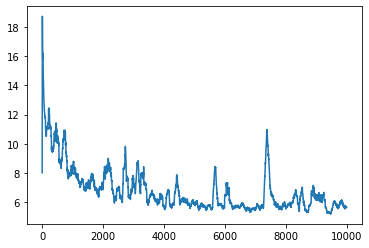

In [ ]:
plt.plot(av_steps)
plt.show()

Next, we will implement the model with true online Sarsa(lambda).  This is being used because the features of the model are not binary

In [ ]:
# initialize model
model = Model()

trace_decay = 0.9


# repeat until convergence
t = 1.0
t2 = 1.0
deltas2 = []
steps2 = []

for it in range(10000):
  done = False
  if it % 10 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("iteration:", it)
  alpha = ALPHA / t2  

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s=env.reset()
  
  # get Q(s) so we can choose the first action
  Qs = getQs(model, s)

  a = max_dict(Qs)[0]
  a = random_action(a, eps=0.5/t) # epsilon-greedy
  # this provides the initial State (s) and action (a) for the episode

  x = model.sa2x(s,a)
  z = np.zeros_like(x)
  Q_old = 0.0
 

  biggest_change = 0
  step_count = 0
  done = False
  while not done:
    step_count += 1
    old_theta = model.theta.copy()
    s2, r, done, _ = env.step((move,a))

    Qs2 = getQs(model, s2)
    a2, maxQs2a2 = max_dict(Qs2)
    a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

    x2 =model.sa2x(s2,a2)
    Q = model.theta.dot(x)
    Q2 = model.theta.dot(x2)

    delta = r + GAMMA * Q2 - Q
    z = GAMMA * trace_decay * z + (1-alpha*GAMMA*trace_decay*z.dot(x))*x
    model.theta += alpha*(delta+Q-Q_old)*z - alpha*(Q-Q_old)*x

    Q_old=Q2
    x = x2
    a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())

  deltas2.append(biggest_change)
  steps2.append(step_count)

iteration: 0
iteration: 1000
iteration: 2000
iteration: 3000
iteration: 4000
iteration: 5000
iteration: 6000
iteration: 7000
iteration: 8000
iteration: 9000


In [ ]:
av_steps2 = []
for i in range(len(steps2)):
  sublist=steps2[max(0,i-100):i+1]
  av_steps2.append(sum(sublist)/len(sublist))

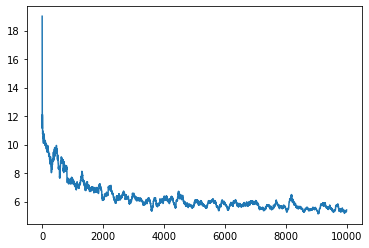

In [ ]:
plt.plot(av_steps2)
plt.show()

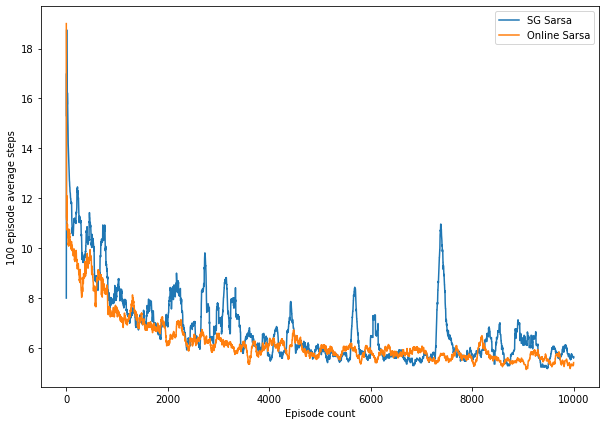

In [76]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(av_steps,label="SG Sarsa")
plt.plot(av_steps2,label="Online Sarsa")
plt.legend()
plt.xlabel("Episode count")
plt.ylabel("100 episode average steps")
plt.show()